In [36]:
from keras.preprocessing.image import image, img_to_array, array_to_img
from keras.models import Sequential, Model
from keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import backend as K
from keras.optimizers import RMSprop
import keras

In [2]:
# allocates GPU memory based on runtime allocations. doesn't releases memory because of potential memory fragmentation
# without this option, getting images will not work
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [145]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [129]:
load_model = False
model_path = ''
model_name = 'facial_expression_normalization_model.h5'

num_classes = 7 #angry, disgust, fear, happy, sad, surprise, neutral
batch_size = 256
epochs = 15
width, height = 48, 48
input_shape = (width, height, 1)

In [5]:
with open("fer2013.csv") as f:
    content = f.readlines()

In [6]:
# see sample content of csv file
print(content[0])
print(content[1])

emotion,pixels,Usage

0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 2

In [7]:
faces = np.array(content)
print("There are {} pictures".format(len(faces)))

There are 35888 pictures


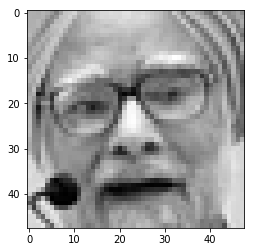

In [9]:
# sample picture
sample = np.array(faces[2].split(",")[1].split(" "))
sample = sample.reshape(width, height, 1)
plt.imshow(array_to_img(sample))

In [23]:
# initialize training and test set
x_train, y_train, x_test, y_test = [], [], [], []

In [24]:
for i, instance in enumerate(faces):
    
    # skip first step; header
    if i == 0:
        continue
    
    emotion, pixel, usage = instance.split(',')
    
    img = np.array(pixel.split(" "))
    emotion = keras.utils.to_categorical(emotion, num_classes)
    
    if 'Training' in usage:
        x_train.append(img)
        y_train.append(emotion)
    else:
        x_test.append(img)
        y_test.append(emotion)
        
print("There are {} training data and {} test cases".format(len(y_train), len(y_test)))

There are 28709 training data and 7178 test cases


In [25]:
# need to convert list into arrays to work with CNNs
x_train = np.array(x_train, 'float32')
y_train = np.array(y_train, 'float32')
x_test = np.array(x_test, 'float32')
y_test = np.array(y_test, 'float32')

# normalize values between 0 - 1
x_train = x_train / 255.0
x_test = x_test / 255.0

# reshape values into image format
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, width, height)
    x_test = x_test.reshape(x_test.shape[0], 1, width, height)
    input_shape = (1, width, height)
else:
    x_train = x_train.reshape(x_train.shape[0], width, height, 1)
    x_test = x_test.reshape(x_test.shape[0], width, height, 1)
    input_shape = (width, height, 1)

In [28]:
# create CNN model
model = Sequential()

# first CNN layer
model.add(Conv2D(49, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))

# second CNN layer
model.add(Conv2D(49, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.2))

# third CNN layer
model.add(Conv2D(98, (3,3), activation='relu'))
model.add(AveragePooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(784, activation='relu'))
model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [104]:
if (load_model):
    model.load(weights(model_path+model_name))
else:
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    model.save_weights(model_path+model_name)

Train on 28709 samples, validate on 7178 samples
Epoch 1/10
28709/28709 [==============================] - 7s 256us/step - loss: 0.8108 - acc: 0.6950 - val_loss: 1.0615 - val_acc: 0.6180
Epoch 2/10
28709/28709 [==============================] - 7s 253us/step - loss: 0.7996 - acc: 0.7041 - val_loss: 1.0467 - val_acc: 0.6225
Epoch 3/10
28709/28709 [==============================] - 7s 254us/step - loss: 0.7666 - acc: 0.7164 - val_loss: 1.0620 - val_acc: 0.6186
Epoch 4/10
28709/28709 [==============================] - 7s 255us/step - loss: 0.7471 - acc: 0.7204 - val_loss: 1.0561 - val_acc: 0.6229
Epoch 5/10
28709/28709 [==============================] - 7s 255us/step - loss: 0.7342 - acc: 0.7293 - val_loss: 1.0556 - val_acc: 0.6269
Epoch 6/10
28709/28709 [==============================] - 7s 255us/step - loss: 0.7123 - acc: 0.7363 - val_loss: 1.0605 - val_acc: 0.6273
Epoch 7/10
28709/28709 [==============================] - 7s 255us/step - loss: 0.7047 - acc: 0.7408 - val_loss: 1.0545 - v

In [121]:
def emotion_breakdown(emotions):
    emotion = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(emotion))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, emotion)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()

In [123]:
def return_confidence(values, diff=.25):
    sorted_values = np.sort(values)

    if sorted_values[-1] - diff > sorted_values[2]:
        return True
    return False

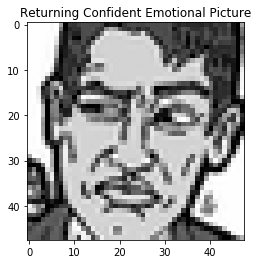

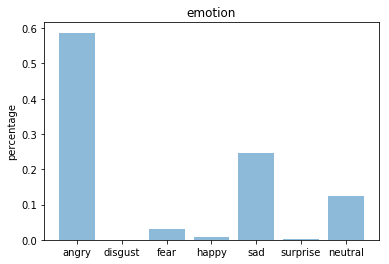

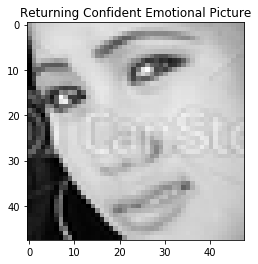

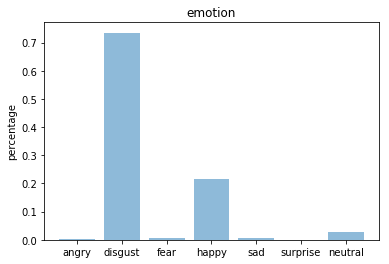

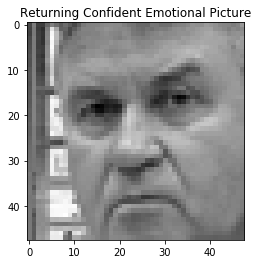

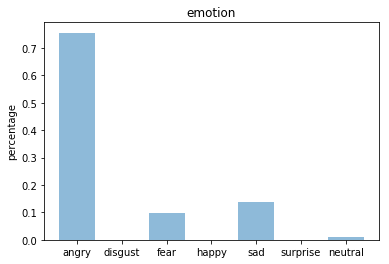

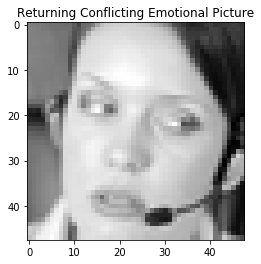

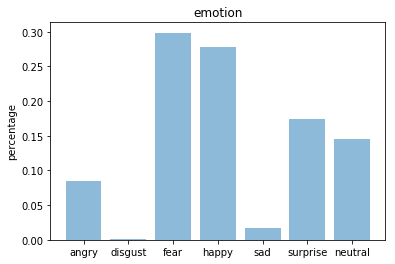

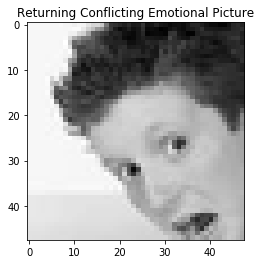

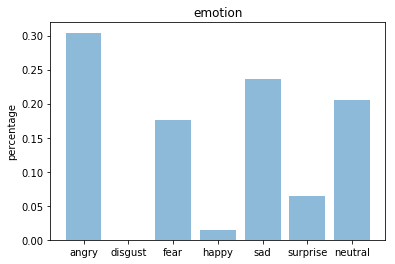

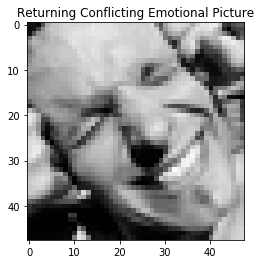

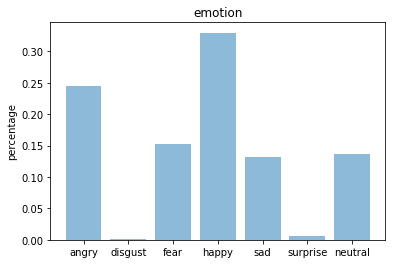

In [149]:
predictions = model.predict(x_test)

num_confident, num_unsure = 0, 0
max_confident, max_unsure = 3, 3

for i, prediction_image in enumerate(predictions):
    
    # only print out up to a certain amount of confident and unsure graphs
    if ((num_confident == max_confident) and (num_unsure == max_unsure)):
        break
    
    val = return_confidence(prediction_image)
    
    if (val and num_confident < max_confident):
        testing_img = np.array(x_test[i], 'float32')
        testing_img = testing_img.reshape(width, height)

        plt.title('Returning Confident Emotional Picture')
        plt.imshow(testing_img)
        plt.show()
        emotion_breakdown(prediction_image)
        
        num_confident += 1
    elif(not val and num_unsure < max_unsure):
        testing_img = np.array(x_test[i], 'float32')
        testing_img = testing_img.reshape(width, height)

        plt.title('Returning Conflicting Emotional Picture')
        plt.imshow(testing_img)
        plt.show()
        emotion_breakdown(prediction_image)
        
        num_unsure += 1

In [142]:
# set up dictionary to generate crosstab
emotion_value = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
dic = {key:value for key, value in zip(list(set(y_test.argmax(axis=-1))), emotion_value)}

# convert id values into string values
prediction_string = []
actual_string = []

for value in predictions.argmax(axis=-1):
    prediction_string.append(dic[value])

for value in y_test.argmax(axis=-1):
    actual_string.append(dic[value])

In [144]:
# create categorical variables to input into crosstab
prediction = pd.Categorical(prediction_string, categories=emotion_value)
actual = pd.Categorical(actual_string, categories=emotion_value)

num_cross = pd.crosstab(prediction, actual, rownames=['Prediction'], colnames=['Actual'])
num_cross

Actual,angry,disgust,fear,happy,sad,surprise,neutral
Prediction,,,,,,,
angry,477,24,103,33,115,28,57
disgust,4,63,0,0,3,0,1
fear,74,4,416,38,111,48,58
happy,77,6,55,1472,75,48,111
sad,164,5,222,88,664,30,196
surprise,24,2,87,32,11,631,8
neutral,138,7,141,111,268,46,802


In [ ]:
# create categorical variables to input into crosstab
prediction = pd.Categorical(prediction_string, categories=stored_value)
actual = pd.Categorical(actual_string, categories=stored_value)

num_cross = pd.crosstab(prediction, actual, rownames=['Prediction'], colnames=['Actual'])
num_cross

In [46]:
# test
test_image = image.load_img('D:/Pictures/2016 San Francisco/IMG_20161204_094714760.jpg',  color_mode='grayscale', target_size=(width, height))

x = image.img_to_array(test_image) / 255.0


if K.image_data_format() == 'channels_first':
    x = x.reshape(1, 1, width, height)
    input_shape = (1, width, height)
else:
    x = x.reshape(1, width, height, 1)
    input_shape = (width, height, 1)
    
prediction = model.predict(x)

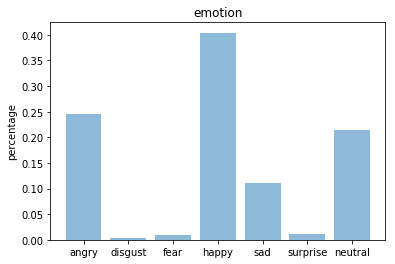

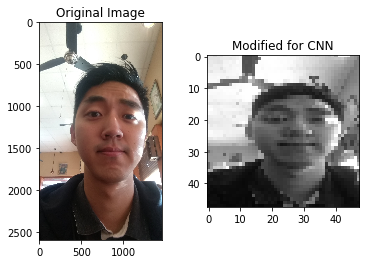

In [60]:
emotion_breakdown(prediction[0])
fig, ax = plt.subplots(1,2)

ax[0].imshow(image.load_img('D:/Pictures/2016 San Francisco/IMG_20161204_094714760.jpg'))
ax[0].set_title('Original Image')

ax[1].imshow(test_image)
ax[1].set_title('Modified for CNN')

plt.show()